# Group Details

## Group Name:

### Student 1:

### Student 2:

### Student 3:

# Loading Data and Preliminaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch

In [3]:
try:
    import torch_geometric
except:
    !pip install torch_geometric
    import torch_geometric

In [4]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [5]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example1 = load_array(notebook_dir+'data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example1
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [6]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time.
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example2 = load_array(notebook_dir+'data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example2
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array(notebook_dir+'data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


In [216]:
np.set_printoptions(suppress=True)
def constant_baseline(X):
    """ x_t = x_0 """
    predictions = []
    for i in range(len(X)):
        mass, x, y, v_x, v_y = X[i]
        final_coords = [x, y]
        predictions.append(final_coords)
    return np.array(predictions)

def linear_baseline(X, t=5):
    """x_t = x_0 + v_0 * t"""

    predictions = []
    for i in range(len(X)):
        mass, x, y, v_x, v_y = X[i]
        final_coords = [x+v_x*t, y+v_y*t]
        predictions.append(final_coords)
    return np.array(predictions)

def sequence_baseline(X, t=50):
    predictions = []
    for i in range(len(X)):
        seq = []
        for j in range(t):
            outp = linear_baseline([X[i]], ((j+1)*0.1))[0]
            seq.append(list(outp))
        predictions.append(seq)
    return np.array(predictions)

def obtain_gt(y):
    truth = []
    for i in range(len(y)):
        seq = []
        for j in range(len(y[i])):
            seq.append([y[i][j][0], y[i][j][1]])
        truth.append(seq)
    return np.array(truth)

system = example1[0]
constant_baseline(system), linear_baseline(system, t=5), sequence_baseline(system)[0][:5]

(array([[-5.27118739,  5.07863417],
        [ 4.3270607 , -0.08095022],
        [-5.15972108,  5.35238208],
        [-6.79584511,  2.29632123],
        [-2.75861066,  1.77940931],
        [ 0.34981219,  4.8286224 ],
        [-0.50562258, 15.04631712],
        [ 1.81342682,  3.84375499]]),
 array([[-10.75571877, -13.26786402],
        [  1.4336244 , -14.87951239],
        [  6.97288106,  12.64591849],
        [ -5.27493319,   0.26332222],
        [ -3.140792  ,  -0.01830862],
        [  7.13136029,  -7.9594037 ],
        [ -5.24424874,  89.95271045],
        [ -1.6814287 ,  -7.41086554]]),
 array([[-5.38087802,  4.71170421],
        [-5.49056864,  4.34477425],
        [-5.60025927,  3.97784428],
        [-5.7099499 ,  3.61091432],
        [-5.81964053,  3.24398435]]))

# Data Handling and Preprocessing

In [ ]:
import os
import sys

t1_train = notebook_dir+'data/task 1/train/'
t1_test = notebook_dir+'data/task 1/test/'
t23_train = notebook_dir+'data/task 2_3/train/'
t23_test = notebook_dir+'data/task 2_3/test/'

t1_train_files = os.listdir(t1_train)
t1_test_files = os.listdir(t1_test)
t23_train_files = os.listdir(t23_train)
t23_test_files = os.listdir(t23_test)

In [218]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class ImportData(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = sorted(os.listdir(folder_path))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        data, label = load_array(file_path, task='task 1')
        return data, label

# Create an instance of the custom dataset class with the folder path
train_import = ImportData(t1_train)
test_import = ImportData(t1_test)

X_train_import = []
y_train_import = []
X_test_import = []
y_test_import = []

# Iterate through the train_dataset to extract data and labels
for data, label in train_import:
    X_train_import.append(data)
    y_train_import.append(label)

for data, label in test_import:
    X_test_import.append(data)
    y_test_import.append(label)

max_length = 9

# Pad the data samples with zeros to have the same shape
X_train_padded = []
for data in X_train_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_train_padded.append(padded_data)

y_train_padded = []
for label in y_train_import:
    pad_width = max_length - label.shape[0]
    padded_label = np.pad(label, ((0, pad_width), (0, 0)), mode='constant')
    y_train_padded.append(padded_label)

X_test_padded = []
for data in X_test_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_test_padded.append(padded_data)

y_test_padded = []
for label in y_test_import:
    pad_width = max_length - label.shape[0]
    padded_label = np.pad(label, ((0, pad_width), (0, 0)), mode='constant')
    y_test_padded.append(padded_label)

# Convert the padded data and labels to tensors
X_train = torch.tensor(np.array(X_train_padded))
y_train = torch.tensor(np.array(y_train_padded))
X_test = torch.tensor(np.array(X_test_padded))
y_test = torch.tensor(np.array(y_test_padded))

# Print the shape of X_train and the first label in y_train
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  torch.Size([900, 9, 5])
y_train shape:  torch.Size([900, 9, 2])
X_test shape:  torch.Size([100, 9, 5])
y_test shape:  torch.Size([100, 9, 2])


In [240]:
import torch
from torch.utils.data import Dataset, DataLoader

# Function to process a single data point
def create_graph(data_point, label):

    #Create node features
    node_features = data_point  # Exclude the mass column

    # Compute edge indices
    edge_indices = []
    for i in range(9):
        for j in range(9):
            if i != j:
                edge_indices.append([i, j])
    edge_indices = torch.tensor(edge_indices).t().contiguous()

    # Compute edge features
    edge_features = []
    for i in range(9):
        for j in range(9):
            if i != j:
                pos = node_features[j] - node_features[i]

                # Calculate Euclidean distance
                # pos = torch.tensor(pos)
                relative_position = torch.norm(pos)
                # print("Relative position: ", relative_position)

                relative_mass = node_features[j, 0] / node_features[i, 0]
                if relative_mass == np.inf or relative_mass == 0:
                    relative_position = 0
                    relative_mass = 0
                # relative_mass = torch.tensor(relative_mass)
                # print("Relative mass: ", relative_mass)
                edge_features.append([relative_position, relative_mass])
                # edge_features.append(torch.cat((relative_position, torch.tensor([relative_mass], dtype=torch.float32))))
    edge_features = torch.FloatTensor(edge_features)

    data = Data(x=node_features, edge_index=edge_indices, edge_attr=edge_features, y=label)

    return data

In [241]:
a = create_graph(X_train[0], y_train[0])
a

Data(x=[9, 5], edge_index=[2, 72], edge_attr=[72, 2], y=[9, 2])

In [247]:
train_graphs_lst = []
for i in range(len(X_train)):
    train_graphs_lst.append(create_graph(X_train[i], y_train[i]))

test_graphs_lst = []
for i in range(len(X_test)):
    test_graphs_lst.append(create_graph(X_test[i], y_test[i]))

In [91]:
# def create_edge(length, i):
#     lst1 = []
#     lst1.extend([i]*(length-1))
#     lst2 = []
#     for j in range(length):
#         if i != j:
#             lst2.append(j)
#     return np.array([lst2, lst1])

# def create_edges(length):
#     lst1 = []
#     for i in range(length):
#         lst1.extend([i]*(length-1))
#     lst2 = []
#     for i in range(length):
#         for j in range(length):
#             if i != j:
#                 lst2.append(j)
#     return np.array([lst1, lst2])

# create_edges(10)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9,
        9, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4,
        5, 6, 7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8,
        9, 0, 1, 2, 3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2,
        3, 4, 5, 6, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6,
        7, 8]])

In [162]:
# import torch
# from torch_geometric.data import Data
# def create_graph(array):
#     num_nodes = len(array[1])
#     edge_indexes = torch.tensor(create_edges(num_nodes), dtype=torch.long)
#     data = Data(x=torch.tensor(array[0], dtype=torch.double),
#                 edge_index=edge_indexes,
#                 y=torch.tensor(array[1]))
#     return data

# def create_graphs(array):
#     lst = []
#     num_nodes = len(array[1])
#     for i in range(num_nodes):
#         edge_indexes = torch.tensor(create_edge(num_nodes, i), dtype=torch.long)
#         data = Data(x=torch.tensor(array[0], dtype=torch.double),
#                     edge_index=edge_indexes,
#                     y=torch.tensor(array[1][i]))
#         lst.append(data)
#     return lst

# data = create_graphs(example1)
# data

[Data(x=[8, 5], edge_index=[2, 7], y=[2]),
 Data(x=[8, 5], edge_index=[2, 7], y=[2]),
 Data(x=[8, 5], edge_index=[2, 7], y=[2]),
 Data(x=[8, 5], edge_index=[2, 7], y=[2]),
 Data(x=[8, 5], edge_index=[2, 7], y=[2]),
 Data(x=[8, 5], edge_index=[2, 7], y=[2]),
 Data(x=[8, 5], edge_index=[2, 7], y=[2]),
 Data(x=[8, 5], edge_index=[2, 7], y=[2])]

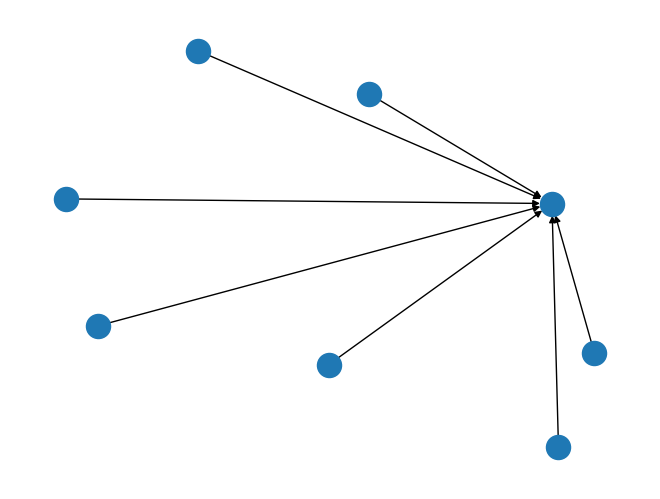

In [156]:
# import networkx as nx
# from torch_geometric.utils import to_networkx
# g = to_networkx(data[0], to_undirected=False)
# nx.draw(g)

# Model Implementation

In [25]:
#todo

# Model Training

In [26]:
#todo

# Evaluation

In [27]:
#todo

In [248]:
# pip install torch_geometric
import torch.nn.functional as F

In [249]:
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(-1, 32)
        self.conv2 = GCNConv(32, 64)
        self.linear = Linear(64, 2)

    def forward(self, x, edge_index, edge_weight=None):
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.linear(x)
        return x

In [131]:
# from torch.nn import Linear
# from torch_geometric.nn import GCNConv


# class GCN(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.gcn = GCNConv(5, 3)
#         self.out = Linear(3, 2)

#     def forward(self, x, edge_index):
#         h = self.gcn(x, edge_index).relu()
#         h = self.out(h)
#         return h

In [254]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(5, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
        )

    def forward(self, x):
        output = self.layers(x)
        return output

In [255]:
# class euclidean(torch.nn.Module): # forgot to define backward()
#     def forward(self, output, target):
#         loss = torch.norm(output-target)
#         return loss

class euclidean(torch.nn.Module): # forgot to define backward()
    def forward(self, output, target):
        loss = torch.norm(output-target, dim=-1)
        return torch.sum(loss)

def compute_sum_euclidean(output, target):
    distance = 0
    output = output.detach().numpy()
    target = target.numpy()
    for i in range(len(target)):
        # print(output[i], target[i])
        dist = np.linalg.norm(output[i] - target[i])
        # print(dist)
        distance += dist
    return distance

MLP

In [256]:
train_graphs_lst[:1]

[Data(x=[9, 5], edge_index=[2, 72], edge_attr=[72, 2], y=[9, 2])]

In [257]:
model = MLP()
print(model)

criterion = euclidean()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def train(lst):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    for data in lst:
        out = model(data.x.float())  # Perform a single forward pass.
        loss = criterion(out.float(), data.y.float())
        distance = compute_sum_euclidean(out, data.y)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        return loss, distance

for epoch in range(1000):
    # data = create_graph(example1)
    loss, dist = train(train_graphs_lst)
    print(f'Epoch: {epoch}, Loss: {loss}, Summed distance: {dist}')

MLP(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)
Epoch: 0, Loss: 140.65313720703125, Summed distance: 140.65313260136355
Epoch: 1, Loss: 151.0332489013672, Summed distance: 151.03324913843596
Epoch: 2, Loss: 125.30228424072266, Summed distance: 125.3022781862516
Epoch: 3, Loss: 104.74185943603516, Summed distance: 104.741851150242
Epoch: 4, Loss: 56.469722747802734, Summed distance: 56.469717333838496
Epoch: 5, Loss: 86.6111068725586, Summed distance: 86.61111654399339
Epoch: 6, Loss: 71.95117950439453, Summed distance: 71.95118423454352
Epoch: 7, Loss: 41.22624206542969, Summed distance: 41.226241372994146
Epoch: 8, Loss: 43.27727127075195, Summed distance: 43.2772680524164
Epoch: 9, Loss: 47.84933090209961, Summed distance: 47.849326110760764
Epoch: 10, Loss: 43.24613952636719, Summed distan

In [145]:
model.eval()
with torch.no_grad():
    outp = model(data.x.float())
outp

tensor([[ 0.2158, -5.5627],
        [-1.1524, -9.4689],
        [-0.3769, -7.0736],
        [-0.3158, -6.2341],
        [-5.9795,  2.5926],
        [ 0.8317, -5.1172],
        [-3.8279, 86.8146],
        [-1.0715, -7.4846]])

In [146]:
data.y

tensor([[ 0.1560, -5.7285],
        [-1.0527, -9.6791],
        [-0.4624, -7.3590],
        [-0.3819, -6.3529],
        [-6.3564,  2.7568],
        [ 0.7670, -5.2778],
        [-5.2653, 89.5328],
        [-0.9416, -7.6763]], dtype=torch.float64)

In [210]:
data.x

tensor([[ 4.5467, -5.2712,  5.0786, -1.0969, -3.6693],
        [ 3.5751,  4.3271, -0.0810, -0.5787, -2.9597],
        [ 2.6773, -5.1597,  5.3524,  2.4265,  1.4587],
        [ 2.2746, -6.7958,  2.2963,  0.3042, -0.4066],
        [ 2.3836, -2.7586,  1.7794, -0.0764, -0.3595],
        [ 4.2860,  0.3498,  4.8286,  1.3563, -2.5576],
        [ 3.0312, -0.5056, 15.0463, -0.9477, 14.9813],
        [ 4.1353,  1.8134,  3.8438, -0.6990, -2.2509]], dtype=torch.float64)

GCN

In [179]:
from torch_geometric.nn import DenseGCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = DenseGCNConv(-1, 32)
        self.conv2 = DenseGCNConv(32, 64)
        self.linear = Linear(64, 2)

    def forward(self, x, edge_index, edge_weight=None):
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.linear(x)
        return x

In [181]:
from torch_geometric.utils import to_dense_adj

to_dense_adj(data.edge_index)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.]]])

In [200]:
model = GCN()
print(model)

# data = create_graph(example1)
data = create_graphs(example1)
data = data[-2]
adj = to_dense_adj(data.edge_index)
model = model.float()
# pred = model(data.x.float(), data.edge_index)
pred = model(data.x.float(), adj)
# pred = model(data.x.float())
pred

GCN(
  (conv1): DenseGCNConv(-1, 32)
  (conv2): DenseGCNConv(32, 64)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


tensor([[[-0.6263, -0.7112],
         [-0.8057, -0.7798],
         [-0.7499, -0.7679],
         [-0.7101, -0.7259],
         [-0.7500, -0.7565],
         [-0.7357, -0.7320],
         [-0.7682, -0.7627],
         [-0.7673, -0.7506]]], grad_fn=<ViewBackward0>)

In [201]:
data.y

tensor([-5.2653, 89.5328], dtype=torch.float64)

In [202]:
criterion = euclidean()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
def train(data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    adj = to_dense_adj(data.edge_index)
    out = model(data.x.float(), adj)  # Perform a single forward pass.
    # out = model(data.x.float())  # Perform a single forward pass.
    loss = criterion(out.float(), data.y.float())
    # print(out, data.y)
    # distance = compute_sum_euclidean(out, data.y)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

for epoch in range(100):
    # data = create_graph(example1)
    loss = train(data)
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 723.1563110351562
Epoch: 1, Loss: 492.3763427734375
Epoch: 2, Loss: 196.11068725585938
Epoch: 3, Loss: 205.84585571289062
Epoch: 4, Loss: 202.72744750976562
Epoch: 5, Loss: 99.06678771972656
Epoch: 6, Loss: 73.33799743652344
Epoch: 7, Loss: 142.56549072265625
Epoch: 8, Loss: 102.82131958007812
Epoch: 9, Loss: 116.76934814453125
Epoch: 10, Loss: 55.14659118652344
Epoch: 11, Loss: 144.88626098632812
Epoch: 12, Loss: 157.08999633789062
Epoch: 13, Loss: 55.96236801147461
Epoch: 14, Loss: 182.52902221679688
Epoch: 15, Loss: 200.927001953125
Epoch: 16, Loss: 67.44950866699219
Epoch: 17, Loss: 154.3133087158203
Epoch: 18, Loss: 212.97061157226562
Epoch: 19, Loss: 189.23892211914062
Epoch: 20, Loss: 85.13546752929688
Epoch: 21, Loss: 140.17453002929688
Epoch: 22, Loss: 197.0714111328125
Epoch: 23, Loss: 106.83326721191406
Epoch: 24, Loss: 71.95423126220703
Epoch: 25, Loss: 127.19091796875
Epoch: 26, Loss: 101.60877227783203
Epoch: 27, Loss: 26.895475387573242
Epoch: 28, Loss: 7

In [203]:
adj = to_dense_adj(data.edge_index)
model(data.x.float(), adj)

tensor([[[-4.7319, 94.9787],
         [-4.7343, 95.7232],
         [-4.7937, 96.4394],
         [-4.6670, 93.7315],
         [-4.7369, 95.3022],
         [-4.7778, 96.5004],
         [-4.4468, 89.7168],
         [-4.8431, 97.8520]]], grad_fn=<ViewBackward0>)

In [204]:
data.y

tensor([-5.2653, 89.5328], dtype=torch.float64)

In [170]:
model.eval()

with torch.no_grad():
    outp = model(data.x.float(), data.edge_index)
outp

tensor([[ 0.3389, -7.7046],
        [ 0.3389, -7.7046],
        [ 0.3389, -7.7046],
        [ 0.3389, -7.7046],
        [ 0.3389, -7.7046],
        [ 0.3389, -7.7046],
        [ 0.3389, -7.7046],
        [ 0.3389, -7.7046]])

In [109]:
data.y

tensor([[ 0.1560, -5.7285],
        [-1.0527, -9.6791],
        [-0.4624, -7.3590],
        [-0.3819, -6.3529],
        [-6.3564,  2.7568],
        [ 0.7670, -5.2778],
        [-5.2653, 89.5328],
        [-0.9416, -7.6763]], dtype=torch.float64)

In [211]:
model = GCN()
print(model)

# data = create_graph(example1)
data = create_graphs(example1)
data = data[-2]
adj = to_dense_adj(data.edge_index)
model = model.float()
# pred = model(data.x.float(), data.edge_index)
pred = model(data.x.float(), adj)
# pred = model(data.x.float())
pred

GCN(
  (conv1): DenseGCNConv(-1, 32)
  (conv2): DenseGCNConv(32, 64)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


tensor([[[-0.7249,  0.1637],
         [-0.7284,  0.1692],
         [-0.7896,  0.0131],
         [-0.7685,  0.0520],
         [-0.7438,  0.1005],
         [-0.7353,  0.1352],
         [-0.6886,  0.0907],
         [-0.7369,  0.1846]]], grad_fn=<ViewBackward0>)

In [212]:
criterion = euclidean()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
def train(data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    adj = to_dense_adj(data.edge_index)
    out = model(data.x.float(), adj)  # Perform a single forward pass.
    # out = model(data.x.float())  # Perform a single forward pass.
    loss = criterion(out.float(), data.y.float())
    # print(out, data.y)
    # distance = compute_sum_euclidean(out, data.y)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

for epoch in range(100):
    # data = create_graph(example1)
    loss = train(data)
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 716.2689819335938
Epoch: 1, Loss: 507.65814208984375
Epoch: 2, Loss: 238.046875
Epoch: 3, Loss: 234.9832305908203
Epoch: 4, Loss: 230.54617309570312
Epoch: 5, Loss: 130.9409637451172
Epoch: 6, Loss: 77.5489273071289
Epoch: 7, Loss: 174.18505859375
Epoch: 8, Loss: 195.310791015625
Epoch: 9, Loss: 121.28236389160156
Epoch: 10, Loss: 150.40902709960938
Epoch: 11, Loss: 71.03009796142578
Epoch: 12, Loss: 150.30050659179688
Epoch: 13, Loss: 197.98818969726562
Epoch: 14, Loss: 152.20135498046875
Epoch: 15, Loss: 94.97129821777344
Epoch: 16, Loss: 127.35231018066406
Epoch: 17, Loss: 51.22698974609375
Epoch: 18, Loss: 127.64900970458984
Epoch: 19, Loss: 163.8959503173828
Epoch: 20, Loss: 117.86187744140625
Epoch: 21, Loss: 78.22858428955078
Epoch: 22, Loss: 103.75994873046875
Epoch: 23, Loss: 37.42152404785156
Epoch: 24, Loss: 113.99258422851562
Epoch: 25, Loss: 133.65032958984375
Epoch: 26, Loss: 75.16162109375
Epoch: 27, Loss: 89.73572540283203
Epoch: 28, Loss: 104.9984283447

In [213]:
model.eval()

with torch.no_grad():
    outp = model(data.x.float(), adj)
outp

tensor([[[-4.7307, 90.5267],
         [-4.7248, 90.2838],
         [-4.8014, 92.0195],
         [-4.6700, 89.4473],
         [-4.7312, 90.6106],
         [-4.7837, 91.5282],
         [-4.4394, 84.8134],
         [-4.8333, 92.4337]]])